# 使用线性回归预测波士顿房价

**作者:** [PaddlePaddle](https://github.com/PaddlePaddle) <br>
**日期:** 2021.01 <br>
**摘要:** 本示例教程将会演示如何使用线性回归完成波士顿房价预测。

## 一、简要介绍
经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 
本示例简要介绍如何用飞桨开源框架，实现波士顿房价预测。其思路是，假设uci-housing数据集中的房子属性和房价之间的关系可以被属性间的线性组合描述。在模型训练阶段，让假设的预测结果和真实值之间的误差越来越小。在模型预测阶段，预测器会读取训练好的模型，对从未遇见过的房子属性进行房价预测。

## 二、环境配置

本教程基于Paddle 2.0 编写，如果您的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.0 。

In [4]:
import paddle
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print(paddle.__version__)

2.0.0


## 三、数据集介绍
本示例采用uci-housing数据集，这是经典线性回归的数据集。数据集共7084条数据，可以拆分成506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。

前13列用来描述房屋的各种信息

![avatar](https://ai-studio-static-online.cdn.bcebos.com/c19602ce74284e3b9a50422f8dc37c0c1c79cf5cd8424994b6a6b073dcb7c057)


### 3.1 数据处理

In [5]:
#下载数据
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data -O housing.data 

--2021-01-27 18:04:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
正在解析主机 archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
正在连接 archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：49082 (48K) [application/x-httpd-php]
正在保存至: “housing.data”

housing.data        100%[===================>]  47.93K   157KB/s  用时 0.3s      

2021-01-27 18:04:48 (157 KB/s) - 已保存 “housing.data” [49082/49082])



In [6]:
# 从文件导入数据
datafile = './housing.data'
housing_data = np.fromfile(datafile, sep=' ')
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
feature_num = len(feature_names)
# 将原始数据进行Reshape，变成[N, 14]这样的形状
housing_data = housing_data.reshape([housing_data.shape[0] // feature_num, feature_num])

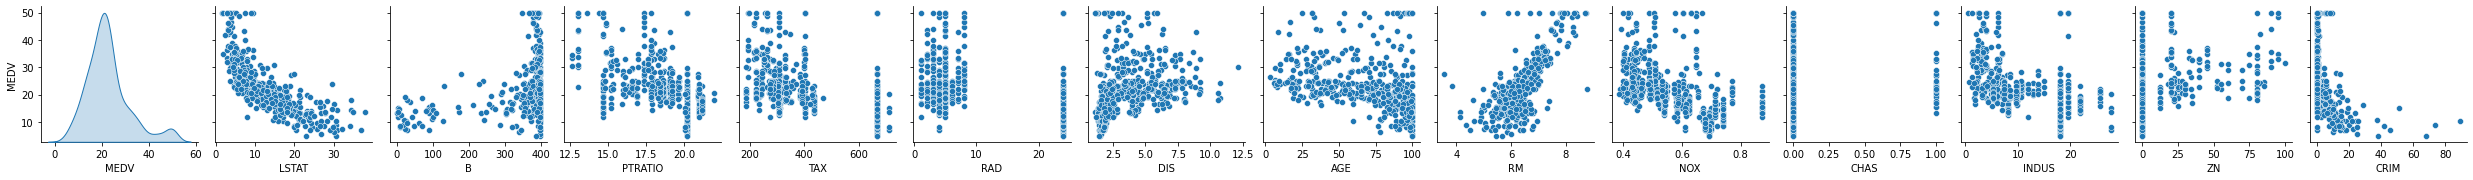

In [7]:
# 画图看特征间的关系,主要是变量两两之间的关系（线性或非线性，有无明显较为相关关系）
features_np = np.array([x[:13] for x in housing_data], np.float32)
labels_np = np.array([x[-1] for x in housing_data], np.float32)
# data_np = np.c_[features_np, labels_np]
df = pd.DataFrame(housing_data, columns=feature_names)
matplotlib.use('TkAgg')
%matplotlib inline
sns.pairplot(df.dropna(), y_vars=feature_names[-1], x_vars=feature_names[::-1], diag_kind='kde')
plt.show()

/Library/Python/3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


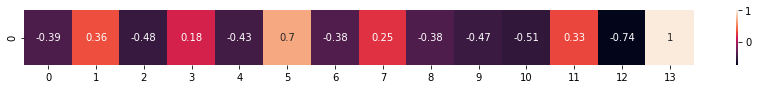

In [8]:
# 相关性分析
fig, ax = plt.subplots(figsize=(15, 1)) 
corr_data = df.corr().iloc[-1]
corr_data = np.asarray(corr_data).reshape(1, 14)
ax = sns.heatmap(corr_data, cbar=True, annot=True)
plt.show()

### 3.2 数据归一化处理

下图为大家展示各属性的取值范围分布：

<AxesSubplot:>

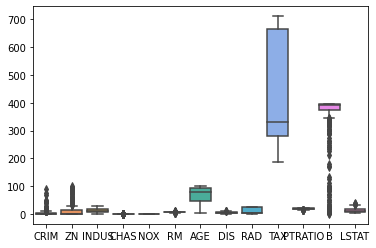

In [9]:
sns.boxplot(data=df.iloc[:, 0:13])

从上图看出，我们各属性的数值范围差异太大，甚至不能够在一个画布上充分的展示各属性具体的最大、最小值以及异常值等。下面我们进行归一化。


做归一化（或 Feature scaling）至少有以下2个理由：

*   过大或过小的数值范围会导致计算时的浮点上溢或下溢。
*   不同的数值范围会导致不同属性对模型的重要性不同（至少在训练的初始阶段如此），而这个隐含的假设常常是不合理的。这会对优化的过程造成困难，使训练时间大大的加长.



In [11]:
features_max = housing_data.max(axis=0)
features_min = housing_data.min(axis=0)
features_avg = housing_data.sum(axis=0) / housing_data.shape[0]

In [12]:
BATCH_SIZE = 20
def feature_norm(input):
    f_size = input.shape
    output_features = np.zeros(f_size, np.float32)
    for batch_id in range(f_size[0]):
        for index in range(13):
            output_features[batch_id][index] = (input[batch_id][index] - features_avg[index]) / (features_max[index] - features_min[index])
    return output_features 

In [13]:
#只对属性进行归一化
housing_features = feature_norm(housing_data[:, :13])
# print(feature_trian.shape)
housing_data = np.c_[housing_features, housing_data[:, -1]].astype(np.float32)
# print(training_data[0])

<AxesSubplot:>

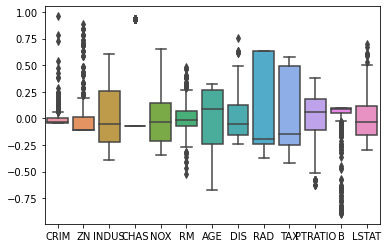

In [14]:
#归一化后的train_data,我们看下各属性的情况
features_np = np.array([x[:13] for x in housing_data],np.float32)
labels_np = np.array([x[-1] for x in housing_data],np.float32)
data_np = np.c_[features_np, labels_np]
df = pd.DataFrame(data_np, columns=feature_names)
sns.boxplot(data=df.iloc[:, 0:13])

In [16]:
#将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(housing_data.shape[0] * ratio)
train_data = housing_data[:offset]
test_data = housing_data[offset:]

## 四、模型组网
线性回归就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

In [17]:
class Regressor(paddle.nn.Layer):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc = paddle.nn.Linear(13, 1,)

    def forward(self, inputs):
        pred = self.fc(inputs)
        return pred

定义绘制训练过程的损失值变化趋势的方法draw_train_process

In [18]:
train_nums = []
train_costs = []

def draw_train_process(iters, train_costs):
    plt.title("training cost", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.show()

## 五、方式1：使用基础API完成模型训练&预测
### 5.1 模型训练
下面为大家展示模型训练的代码。

这里用到的是线性回归模型最常用的损失函数--均方误差（MSE），用来衡量模型预测的房价和真实房价的差异。

对损失函数进行优化所采用的方法是梯度下降法.

In [19]:
import paddle.nn.functional as F 
y_preds = []
labels_list = []

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 500
    train_num = 0
    optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :13], np.float32)
            labels_np = np.array(data[:, -1:], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            #前向计算
            y_pred = model(features)
            cost = F.mse_loss(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            #反向传播
            cost.backward()
            #最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)
        
model = Regressor()
train(model)

start training ... 
Pass:0,Cost:724.19617
Pass:50,Cost:62.97696
Pass:100,Cost:96.54344
Pass:150,Cost:49.87206
Pass:200,Cost:32.18977
Pass:250,Cost:30.61844
Pass:300,Cost:42.43702
Pass:350,Cost:63.68068
Pass:400,Cost:31.93441
Pass:450,Cost:18.98611


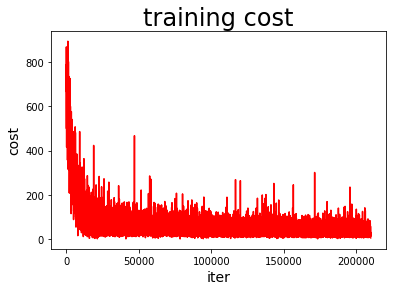

In [20]:
matplotlib.use('TkAgg')
%matplotlib inline
draw_train_process(train_nums, train_costs)

可以从上图看出，随着训练轮次的增加，损失在呈降低趋势。但由于每次仅基于少量样本更新参数和计算损失，所以损失下降曲线会出现震荡。

### 5.2 模型预测

In [21]:
#获取预测数据
INFER_BATCH_SIZE = 100

infer_features_np = np.array([data[:13] for data in test_data]).astype("float32")
infer_labels_np = np.array([data[-1] for data in test_data]).astype("float32")

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)
fetch_list = model(infer_features)

sum_cost = 0
for i in range(INFER_BATCH_SIZE):
    infer_result = fetch_list[i][0]
    ground_truth = infer_labels[i]
    if i % 10 == 0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result, ground_truth))
    cost = paddle.pow(infer_result - ground_truth, 2)
    sum_cost += cost
mean_loss = sum_cost / INFER_BATCH_SIZE
print("Mean loss is:", mean_loss.numpy())

No.0: infer result is 12.00,ground truth is 8.50
No.10: infer result is 5.56,ground truth is 7.00
No.20: infer result is 15.01,ground truth is 11.70
No.30: infer result is 16.49,ground truth is 11.70
No.40: infer result is 13.58,ground truth is 10.80
No.50: infer result is 15.98,ground truth is 14.90
No.60: infer result is 18.70,ground truth is 21.40
No.70: infer result is 15.55,ground truth is 13.80
No.80: infer result is 18.15,ground truth is 20.60
No.90: infer result is 21.36,ground truth is 24.50
Mean loss is: [12.574625]


In [22]:
def plot_pred_ground(pred, ground):
    plt.figure()   
    plt.title("Predication v.s. Ground truth", fontsize=24)
    plt.xlabel("ground truth price(unit:$1000)", fontsize=14)
    plt.ylabel("predict price", fontsize=14)
    plt.scatter(ground, pred, alpha=0.5)  #  scatter:散点图,alpha:"透明度"
    plt.plot(ground, ground, c='red')
    plt.show()

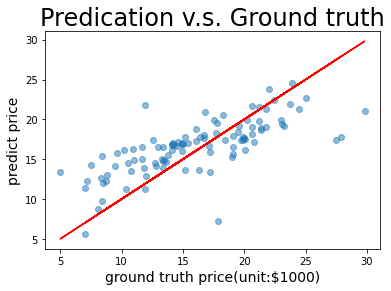

In [23]:
plot_pred_ground(fetch_list, infer_labels_np)

上图可以看出，我们训练出来的模型的预测结果与真实结果是较为接近的。

## 六、方式2：使用高层API完成模型训练&预测
我们也可以用我们的高层API来做线性回归训练，高层API相较于底层API更加的简洁方便。

In [25]:
import paddle
paddle.set_default_dtype("float64")

#step1:用高层API定义数据集，无需进行数据处理等，高层API为您一条龙搞定
train_dataset = paddle.text.datasets.UCIHousing(mode='train')
eval_dataset = paddle.text.datasets.UCIHousing(mode='test')

#step2:定义模型
class UCIHousing(paddle.nn.Layer):
    def __init__(self):
        super(UCIHousing, self).__init__()
        self.fc = paddle.nn.Linear(13, 1, None)

    def forward(self, input):
        pred = self.fc(input)
        return pred

#step3:训练模型
model = paddle.Model(UCIHousing())
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),
              paddle.nn.MSELoss())
model.fit(train_dataset, eval_dataset, epochs=5, batch_size=8, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 51/51 [==============================] - loss: 628.4189 - 2ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 13/13 [==============================] - loss: 385.1105 - 990us/step        
Eval samples: 102
Epoch 2/5
step 51/51 [==============================] - loss: 416.6072 - 2ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 13/13 [==============================] - loss: 382.5877 - 1ms/step          
Eval samples: 102
Epoch 3/5
step 51/51 [==============================] - loss: 417.1789 - 1ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 13/13 [==============================]